In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#import plotnine
#from plotnine import *

In [2]:
# 경로 설정
data_path = '/Data2/hm22/New/data'
saved_path = '/Data2/hm22/New/code/saved'
output_path = '/Data2/hm22/New/code/submission'

In [3]:
# 데이터 불러오기 
history = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
watch = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
# buy = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')  # 사용 X
search = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
profile = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

In [4]:
hd = history.copy()
wd = watch.copy()
#bd = buy.copy()
sd = search.copy()
prd = profile.copy()

In [5]:
print('hd 데이터(중복 제거 전) : ', hd.shape)
print('wd 데이터(중복 제거 전) : ', wd.shape)
print('sd 데이터(중복 제거 전) : ', sd.shape)
print('prd 데이터(중복 제거 전) : ', prd.shape)

hd 데이터(중복 제거 전) :  (1005651, 8)
wd 데이터(중복 제거 전) :  (892794, 8)
sd 데이터(중복 제거 전) :  (6474, 5)
prd 데이터(중복 제거 전) :  (8311, 9)


### 0. 기초

#### 0-1. 필요없는 column drop
    - hd : ss_id
    - wd : ss_id, log_time
    - sd : ss_id

In [6]:
hd = hd.drop(["ss_id"], axis=1)
sd = sd.drop(["ss_id"], axis=1)
wd = wd.drop(["ss_id", "log_time"], axis=1)

print('hd 데이터(행 삭제 완료) : ', hd.shape)
print('wd 데이터(행 삭제 완료) : ', wd.shape)
print('sd 데이터(행 삭제 완료) : ', sd.shape)

hd 데이터(행 삭제 완료) :  (1005651, 7)
wd 데이터(행 삭제 완료) :  (892794, 6)
sd 데이터(행 삭제 완료) :  (6474, 4)


#### 0-2. hd의 continuous_play,  wd의 continuous_play 동일하게 바꿔주기

In [7]:
hd['continuous_play'].value_counts().to_frame()

,continuous_play
Y,889517
N,116134


In [8]:
# 시청 시작 데이터에서 연속재생여부 Y -> 1: 연속재생, N -> 5: 미정 으로 변환
hd.loc[(hd['continuous_play'] == 'Y'), 'continuous_play'] = 1
hd.loc[(hd['continuous_play'] == 'N'), 'continuous_play'] = 0

# 시청 종료 데이터에서 연속재생 1이 아닌 경우 (0,2,3) -> 0으로 변환
wd.loc[(wd['continuous_play'] == 2) |
       (wd['continuous_play'] == 3), 'continuous_play'] = 0

In [9]:
hd['continuous_play'].value_counts().to_frame()

,continuous_play
1,889517
0,116134


In [10]:
wd['continuous_play'].value_counts().to_frame()

,continuous_play
1,500524
0,392270


### 1. 중복 데이터 제거

In [12]:
# 중복행 확인
hd[hd.duplicated([])] # 시청시작 데이터

,profile_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
517,5,20220421082957,MKID003,92,NaN,0,N
519,5,20220421085009,MKID003,174,NaN,0,N
521,5,20220421090237,MKID003,201,NaN,0,N
523,5,20220421090332,MKID003,187,NaN,0,N
525,5,20220421090449,MKID003,305,NaN,0,N
...,...,...,...,...,...,...,...
1004498,32908,20220420204139,MKID003,6458,NaN,0,N
1005467,33015,20220424194036,MKID003,416,NaN,1,N
1005469,33015,20220424194091,MKID003,175,NaN,0,Y
1005471,33015,20220424195612,MKID003,57,NaN,0,N


In [13]:
wd[wd.duplicated([])] # 시청종료 데이터

,profile_id,act_target_dtl,album_id,watch_time,total_time,continuous_play
18,3,MKID049,20,119,119,1
67,5,MKID049,102,80,80,1
100,5,MKID049,77,299,301,1
102,5,MKID049,78,41,43,1
104,5,MKID049,79,41,41,1
...,...,...,...,...,...,...
892787,33032,MKID049,381,462,463,1
892788,33032,MKID049,381,463,464,1
892789,33032,MKID049,381,463,464,1
892790,33032,MKID049,381,462,463,1


In [14]:
sd[sd.duplicated([])] # 검색 데이터

,profile_id,log_time,act_target_dtl,album_id
1,59,20220303183914,MKID017,2141
2,59,20220303183914,MKID017,2141
11,59,20220401092812,MKID017,2157
13,59,20220401092842,MKID017,2158
67,572,20220306172797,MKID017,2867
...,...,...,...,...
6366,32000,20220404195946,MKID017,2009
6367,32000,20220404195946,MKID017,2009
6387,32193,20220413135982,MKID017,26071
6402,32322,20220328180237,MKID017,10006


In [15]:
# 중복행 제거
hd = hd[~hd.duplicated()]
print('hd 데이터(중복 제거 후) : ', hd.shape) # 약 10% 감소

wd = wd[~wd.duplicated()]
print('wd 데이터(중복 제거 후) : ', wd.shape) # 약 10% 감소

sd = sd[~sd.duplicated()]
print('sd 데이터(중복 제거 후) : ', sd.shape)

hd 데이터(중복 제거 후) :  (899269, 7)
wd 데이터(중복 제거 후) :  (615480, 6)
sd 데이터(중복 제거 후) :  (5825, 4)


### 2. 결측치 제거

#### 2-1. History data 내 payment
**방법 설명** : 
1) ID 로 groupby를 해준 뒤, ID 별 payment의 합을 구한다.

2) ID 별 payment의 합 == 0 이면, 해당 ID 의 payment 정보는 누락된 것으로 간주한다.

3) payment 정보가 누락된 ID가 누구인지 추출한다.

4) 해당 ID의 payment 결측값을 0으로 대체한다.

5) 그 외 여전히 payment가 null인 행은 같은 ID의 과거 payment 내역을 기입한다. (이 방법은 하지 않음- 위 방법으로 payment가 null인 값은 모두 각 ID의 payment 정보가 누락된 것이 확인됨)

In [16]:
hd.isnull().sum(), wd.isnull().sum(), sd.isnull().sum()

(profile_id              0
 log_time                0
 act_target_dtl          0
 album_id                0
 payment            840076
 continuous_play         0
 short_trailer           0
 dtype: int64,
 profile_id         0
 act_target_dtl     0
 album_id           0
 watch_time         0
 total_time         0
 continuous_play    0
 dtype: int64,
 profile_id        0
 log_time          0
 act_target_dtl    0
 album_id          0
 dtype: int64)

In [17]:
def nonull(df) :
    
    print("null 값 대체 전 결측치 개수 : ", df['payment'].isnull().sum()) #null 값 대체 전 결측치 개수
    
    # ID 별 payment의 합을 구하기
    ddff = df.groupby('profile_id').sum()
    
    print("payment의 합 == 0인 ID 개수 : ", len(ddff[ddff['payment'] == 0.0].index)) #payment의 합 == 0인 ID 개수
    
    """
    아래 코드 잘못됨
    for i in ddff[ddff['payment'] == 0.0].index : 
        if all(dfcp['profile_id'] == i) :
            dfcp['payment_nonan'] = dfcp['payment'].fillna(0) #payment 정보가 누락된 ID가 누구인지 추출한 후, 해당 ID의 payment 결측값을 0으로 대체
    """ 
    
    for i in ddff[ddff['payment'] == 0.0].index: 
        df[df['profile_id'] == i]
        df['payment_nonan'] = df['payment'].fillna(0) #payment 정보가 누락된 ID가 누구인지 추출한 후, 해당 ID의 payment 결측값을 0으로 대체
    
    
    a = df[df['payment_nonan'] != 0.0]['payment']
    b = df[df['payment'].notnull()]['payment']
    
    print(a.equals(b))
    
    df.drop(labels='payment',axis=1, inplace = True)
    df.rename(columns={'payment_nonan':'payment'}, inplace = True)
    
    print("null 값 대체 후 결측치 개수 : ", df['payment'].isnull().sum()) #null 값 대체 후 결측치 개수
    
    return df

In [18]:
hd = nonull(hd)

null 값 대체 전 결측치 개수 :  840076
payment의 합 == 0인 ID 개수 :  6619
True
null 값 대체 후 결측치 개수 :  0


#### 2-2. Profile data 내 결측치 처리

In [19]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,1533
pr_interest_keyword_cd_3,2080
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,1693
ch_interest_keyword_cd_3,2282


**- 결측값 있는 columns**

    - pr_interest_keyword_cd_2(부모 관심 키워드2): 1533
    - pr_interest_keyword_cd_3(부모 관심 키워드3): 2080
    - ch_interest_keyword_cd_2(아이 관심 키워드2): 1693
    - ch_interest_keyword_cd_3(아이 관심 키워드3): 2282

**- 방법 : 키워드1과 동일한 값 2,3에 채우기**

In [20]:
prd[prd['pr_interest_keyword_cd_2'].isnull()]

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
7,22,F,4,P06,NaN,NaN,K01,NaN,NaN
22,74,M,2,P02,NaN,NaN,K03,NaN,NaN
33,115,M,4,P06,NaN,NaN,K01,NaN,NaN
37,122,M,3,P05,NaN,NaN,K08,NaN,NaN
41,130,F,10,P07,NaN,NaN,K06,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8290,32965,M,1,P01,NaN,NaN,K01,K08,NaN
8294,32978,F,4,P06,NaN,NaN,K06,K01,K03
8297,32984,F,4,P06,NaN,NaN,K01,K02,K04
8301,33000,M,3,P07,NaN,NaN,K01,NaN,NaN


In [21]:
prd['pr_interest_keyword_cd_2'] = prd['pr_interest_keyword_cd_2'].fillna(prd['pr_interest_keyword_cd_1'])
prd['pr_interest_keyword_cd_3'] = prd['pr_interest_keyword_cd_3'].fillna(prd['pr_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_2'] = prd['ch_interest_keyword_cd_2'].fillna(prd['ch_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_3'] = prd['ch_interest_keyword_cd_3'].fillna(prd['ch_interest_keyword_cd_1'])

In [22]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,0
pr_interest_keyword_cd_3,0
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,0
ch_interest_keyword_cd_3,0


### 3. 이상치 제거

#### 3-1. History_data 내 log_time 이상치 제거

In [23]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115719,MKID003,15,1,N,0.0
1,3,20220301115809,MKID003,16,1,N,0.0
2,3,20220301115958,MKID003,17,1,N,0.0
3,3,20220301120118,MKID003,18,1,N,0.0
4,3,20220301120229,MKID003,19,1,N,0.0


In [24]:
# log_time 날짜/시간 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["date"] = hd["log_time"].str.slice(0, 8)
hd["time"] = hd["log_time"].str.slice(8, 14)

In [25]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,date,time
0,3,20220301115719,MKID003,15,1,N,0.0,20220301,115719
1,3,20220301115809,MKID003,16,1,N,0.0,20220301,115809
2,3,20220301115958,MKID003,17,1,N,0.0,20220301,115958
3,3,20220301120118,MKID003,18,1,N,0.0,20220301,120118
4,3,20220301120229,MKID003,19,1,N,0.0,20220301,120229


In [26]:
# 월 조건 (3 ~ 7월 제외한 월이 있는지)
con1 = (hd['date'].str[4:6] != '03')
con2 = (hd['date'].str[4:6] != '04')
con3 = (hd['date'].str[4:6] != '05')
con4 = (hd['date'].str[4:6] != '06')
con5 = (hd['date'].str[4:6] != '07')

# 일 조건 (0일 / 00일 / 32일 이상 있는지)
con8 = (hd['date'].str[6:8] == '0')
con9 = (hd['date'].str[6:8] == '00')
con10 = (hd['date'].str[6:8].astype(int) >= 32)

In [27]:
print('조건에 맞지 않는 연도 수:', len(hd.loc[hd['date'].str[:4] != '2022']))
print('조건에 맞지 않는 월 수:', len(hd.loc[con1 & con2 & con3 & con4 & con5]))
print('조건에 맞지 않는 일 수:', len(hd.loc[con8 | con9 | con10]))
print('조건에 맞지 않는 시 수:', len(hd.loc[hd['time'].str[:2] >= '24']))
print('조건에 맞지 않는 분 수:', len(hd.loc[hd['time'].str[2:4] >= '60']))
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 연도 수: 0
조건에 맞지 않는 월 수: 0
조건에 맞지 않는 일 수: 0
조건에 맞지 않는 시 수: 0
조건에 맞지 않는 분 수: 0
조건에 맞지 않는 초 수: 73580


In [28]:
# 초에만 이상 있음
# 이상 있는 데이터 73,581개
hd.loc[hd['time'].str[4:6] >= '60']

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,date,time
2975,30,20220305131273,MKID003,1901,1,N,0.0,20220305,131273
2976,30,20220305132966,MKID003,1902,1,N,0.0,20220305,132966
2978,30,20220305134092,MKID003,1903,1,N,0.0,20220305,134092
2983,30,20220320140174,MKID003,446,0,N,500.0,20220320,140174
2988,30,20220320144788,MKID003,1908,1,N,500.0,20220320,144788
...,...,...,...,...,...,...,...,...,...
1005638,33032,20220427154870,MKID003,7105,0,N,0.0,20220427,154870
1005639,33032,20220427155075,MKID003,1725,1,N,0.0,20220427,155075
1005646,33032,20220427155668,MKID003,381,1,N,0.0,20220427,155668
1005647,33032,20220427155680,MKID003,381,1,N,0.0,20220427,155680


In [29]:
# 이상 데이터 제거
hd = hd.drop(hd.loc[hd['time'].str[4:6] >= '60'].index)
print('이상 데이터 제거 후:', len(hd))

이상 데이터 제거 후: 825689


In [30]:
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 초 수: 0


In [31]:
hd.drop(labels=['date', 'time'],axis=1, inplace = True)
# log_time type 다시 int형으로 변경
hd["log_time"] = hd["log_time"].astype(int)

#### 3-2. Watch_data 내 시청시간, 콘텐츠 길이 이상치 제거

<span style='background-color: #ffdce0'>**방법 1**</span>

In [32]:
wd.head()

,profile_id,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,MKID049,15,46,46,1
1,3,MKID049,16,104,105,1
2,3,MKID049,17,76,76,1
3,3,MKID049,18,67,68,1
4,3,MKID049,19,90,90,0


In [33]:
target_outlier_wd = ['watch_time', 'total_time']
outlier_wd = wd[['profile_id', 'act_target_dtl', 'album_id', 'continuous_play'] + target_outlier_wd]
outlier_wd

,profile_id,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,MKID049,15,1,46,46
1,3,MKID049,16,1,104,105
2,3,MKID049,17,1,76,76
3,3,MKID049,18,1,67,68
4,3,MKID049,19,0,90,90
...,...,...,...,...,...,...
892782,33032,MKID049,3625,0,9,66
892783,33032,MKID049,375,1,658,659
892786,33032,MKID049,125,0,6,520
892791,33032,MKID049,125,0,10,520


In [34]:
import pandas as pd # 이거 import 다시 해줘야 에러 안남 왜지
criteria = pd.DataFrame()

for col in target_outlier_wd :
    values = outlier_wd[col]
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    criteria = pd.concat([criteria, values.between(lower_bound,upper_bound)], axis=1)
    

# AttributeError: 'DataFrame' object has no attribute 'DataFrame' 에러 나만 뜨는건가...후

In [35]:
outlier_wd = outlier_wd[criteria.all(axis=1)]
outlier_wd

,profile_id,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,MKID049,15,1,46,46
1,3,MKID049,16,1,104,105
2,3,MKID049,17,1,76,76
3,3,MKID049,18,1,67,68
4,3,MKID049,19,0,90,90
...,...,...,...,...,...,...
892782,33032,MKID049,3625,0,9,66
892783,33032,MKID049,375,1,658,659
892786,33032,MKID049,125,0,6,520
892791,33032,MKID049,125,0,10,520


In [36]:
print('wd 데이터(이상치 제거 전) : ', wd.shape)
print('wd 데이터(이상치 제거 후) : ', outlier_wd.shape)

wd 데이터(이상치 제거 전) :  (615480, 6)
wd 데이터(이상치 제거 후) :  (590508, 6)


<span style='background-color: #ffdce0'>**방법 2 : LocalOutlierFactor 사용**</span>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
wd.columns

In [ ]:
wd = wd.set_index(['profile_id', 'album_id'])
wd.drop(['act_target_dtl', 'continuous_play', 'continuous_play'], axis = 1, inplace = True)
# hd3 = hd3.drop(['act_target_dtl', 'continuous_play', 'short_trailer'], axis = 1)
# 여기서 drop 해줬으므로 나중에 아래 컬럼 다시 붙여주어야함
# hd3+ = hd[['act_target_dtl', 'continuous_play', 'short_trailer']]

In [ ]:
wd

In [ ]:
outlier = LocalOutlierFactor()
wd["outlier"] = outlier.fit_predict(wd)

In [ ]:
# 이상치 탐지 (이상치 있는 행 찾기)
wd[wd["outlier"] == -1]

In [ ]:
# 이상치 있는 행 삭제
wd = wd.drop(wd[wd["outlier"] == -1].index, axis = 0)
wd.drop(["outlier"],axis = 1, inplace = True)

#### 3-3. History_data 내 payment 이상치 제거

<span style='background-color: #ffdce0'>이상치 제거 말고 로그변환으로 맞추는건 어떨지?</span>

### 4. 범주형 데이터 인코딩

범주형 변수는 다시 명목형 변수(Nominal)와 순서형 변수(Oridinal)로 구분할 수 있습니다.

- 명목형 변수 : 성별과 혈액형처럼 값이 달라짐에 따라 좋거나 나쁘다고 할 수 없는 경우

        → 여러 카테고리들 중 하나의 이름에 데이터를 분류할 수 있을 때 사용

- 순서형 변수 : 학점과 만족도 조사처럼 값이 커지거나 작아짐에 따라 좋거나 나쁘다고 할 수 있는 경우

        → 카테고리들이 순서가 있을 때 사용 (상/중/하, A+/A0/B+/B0...)

#### 4-1. History_data & Watch_data & Search_data

In [37]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115719,MKID003,15,1,N,0.0
1,3,20220301115809,MKID003,16,1,N,0.0
2,3,20220301115958,MKID003,17,1,N,0.0
3,3,20220301120118,MKID003,18,1,N,0.0
4,3,20220301120229,MKID003,19,1,N,0.0


- **continuous_play, short_trailer**: 이진변수 (-> 0, 1로 변경)
    - continuous_play (위 0에서 수행 완료했으므로 생략)
        - 연속재생x: 0
        - 연속재생o: 1
    - short_trailer
        - N: 0
        - Y: 1

In [ ]:
"""
hd.loc[hd['short_trailer'] == 'Y']
hd.loc[hd['short_trailer'] == 'N']
"""

In [38]:
hd['short_trailer'] = hd['short_trailer'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
"""
hd.loc[hd['short_trailer'] == 1]
hd.loc[hd['short_trailer'] == 0]
"""

- **act_target_dtl**
    - MKID### 형태 -> MKID 문자 제거

In [39]:
hd['act_target_dtl'] = hd['act_target_dtl'].str.split('D').str[1]
wd['act_target_dtl'] = wd['act_target_dtl'].str.split('D').str[1]
sd['act_target_dtl'] = sd['act_target_dtl'].str.split('D').str[1]

In [40]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115719,003,15,1,0,0.0
1,3,20220301115809,003,16,1,0,0.0
2,3,20220301115958,003,17,1,0,0.0
3,3,20220301120118,003,18,1,0,0.0
4,3,20220301120229,003,19,1,0,0.0


#### 4-2. Profile_data

In [41]:
prd.head()

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,P05,K06,K04,K06
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04


- **Sex** : 이진변수
    - 0: 여자 F
    - 1: 남자 M

In [42]:
prd['sex'] = prd['sex'].apply(lambda x: 1 if x == 'M' else 0)

In [43]:
prd.head()

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,0,5,P02,P04,P07,K01,K03,K04
1,5,1,5,P07,P08,P06,K05,K08,K09
2,7,0,9,P05,P03,P05,K06,K04,K06
3,12,1,6,P03,P06,P02,K09,K07,K03
4,16,0,12,P03,P06,P01,K01,K06,K04


 - **pr_interest_keyword_cd_1**
 - **pr_interest_keyword_cd_2**
 - **pr_interest_keyword_cd_3**
 - **ch_interest_keyword_cd_1**
 - **ch_interest_keyword_cd_2**
 - **ch_interest_keyword_cd_3**

<span style='background-color: #fff5b1'>**1) One-hot encoding 적용**</span>

- 컬럼이 많이 만들어짐 ⇒ 메모리 문제

In [ ]:
"""
prd = pd.get_dummies(prd)
prd
"""

<span style='background-color: #fff5b1'>**2) Label encoding 적용**</span>

- 단순히 문자형을 정수형으로 변환시켜주므로 데이터의 크기 및 shape이 변하지 않음
- 모델이 숫자의 순서를 특징으로 인식하는 문제 있음

In [ ]:
# Label Encoding
"""
from sklearn.preprocessing import LabelEncoder

for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] :
    encoder = LabelEncoder()
    encoder.fit(prd[i])
    prd[i] = encoder.transform(prd[i])
"""

<span style='background-color: #fff5b1'>**3) Target encoding 적용**</span>

- cross-validation과 smoothing을 함께 사용해서 과적합을 방지 -> smoothing 만 해봄
- 효과 미비하다는 의견 봄
- 특정한 Y 변수가 필요한데 profile_id는 없음..

In [ ]:
"""
from sklearn.preprocessing import TargetEncoder
    
for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    target_encoder = TargetEncoder(cols=[i])
    target_encoder.fit(df[i], df['y값이 없음..... 음....?'])
    new_df = pd.concat([new_df, target_encoder.transform(train[i])], axis = 1)
    #new_test = pd.concat([new_test, target_encoder.transform(test[column])], axis = 1)
new_df.head()
"""

"""
def target_encoding(var):
    mean= df['y'].mean()
    agg= df.groupby(var)['y'].agg(["count", "mean"])
    counts = agg["count"]
    means = agg["mean"]
    weight= 100
    smooth= (counts*means +weight*means) /(counts+weight)
    df.loc[:, var+"_encode_smooth"]= df[var].map(smooth)
    return df
"""

<span style='background-color: #fff5b1'>**4) Frequency encoding 적용 ✔️**</span>

In [ ]:
"""
#!pip install kaggler
import kaggler
from kaggler.preprocessing import FrequencyEncoder

for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    dff = prd.copy()
    fe = FrequencyEncoder()
    dff[i] = fe.fit_transform(prd[i])
    dff[i].head()
"""

In [44]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,0
pr_interest_keyword_cd_3,0
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,0
ch_interest_keyword_cd_3,0


In [45]:
# 주의 : 결측치가 없어야함
for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    enc_1 = (prd.groupby(i).size()) / len(prd)
    enc_1
    
    prd['{}_encode'.format(i)] = prd[i].apply(lambda x : enc_1[x])
    
#인코딩 전 변수는 제거 
prd = prd.drop(['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
                'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'],axis=1)


In [46]:
prd

,profile_id,sex,age,pr_interest_keyword_cd_1_encode,pr_interest_keyword_cd_2_encode,pr_interest_keyword_cd_3_encode,ch_interest_keyword_cd_1_encode,ch_interest_keyword_cd_2_encode,ch_interest_keyword_cd_3_encode
0,3,0,5,0.184093,0.093611,0.178438,0.403562,0.178799,0.105884
1,5,1,5,0.131512,0.078089,0.199374,0.051859,0.083023,0.089520
2,7,0,9,0.093731,0.149320,0.102394,0.062207,0.116111,0.104921
3,12,1,6,0.128865,0.211888,0.127903,0.033209,0.047527,0.157622
4,16,0,12,0.128865,0.211888,0.079293,0.403562,0.092167,0.105884
...,...,...,...,...,...,...,...,...,...
8306,33022,1,1,0.069787,0.093611,0.086271,0.088798,0.083023,0.105884
8307,33023,1,5,0.194080,0.149320,0.178438,0.063169,0.116111,0.095777
8308,33026,0,8,0.163037,0.149320,0.097341,0.051859,0.060643,0.104921
8309,33027,0,4,0.069787,0.106245,0.199374,0.135483,0.153652,0.095777


### 5. 수치형 데이터 인코딩

In [47]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115719,003,15,1,0,0.0
1,3,20220301115809,003,16,1,0,0.0
2,3,20220301115958,003,17,1,0,0.0
3,3,20220301120118,003,18,1,0,0.0
4,3,20220301120229,003,19,1,0,0.0


In [54]:
wd.head()

,profile_id,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,049,15,46,46,1
1,3,049,16,104,105,1
2,3,049,17,76,76,1
3,3,049,18,67,68,1
4,3,049,19,90,90,0


In [55]:
sd.head()

,profile_id,log_time,act_target_dtl,album_id
0,59,20220303183914,017,2141
3,59,20220304181525,017,512
4,59,20220304182447,017,2141
5,59,20220312071637,017,2142
6,59,20220312081857,017,2142


In [56]:
prd.head()

,profile_id,sex,age,pr_interest_keyword_cd_1_encode,pr_interest_keyword_cd_2_encode,pr_interest_keyword_cd_3_encode,ch_interest_keyword_cd_1_encode,ch_interest_keyword_cd_2_encode,ch_interest_keyword_cd_3_encode
0,3,0,5,0.184093,0.093611,0.178438,0.403562,0.178799,0.105884
1,5,1,5,0.131512,0.078089,0.199374,0.051859,0.083023,0.089520
2,7,0,9,0.093731,0.149320,0.102394,0.062207,0.116111,0.104921
3,12,1,6,0.128865,0.211888,0.127903,0.033209,0.047527,0.157622
4,16,0,12,0.128865,0.211888,0.079293,0.403562,0.092167,0.105884


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
# Select numerical columns from dataset
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_hd = hd.select_dtypes(include=numerics)

# fig setting
sns.set(rc = {'figure.figsize':(10, 7)})
sns.set(style="white")

for col in num_hd.columns :
    sns.distplot(hd[col])

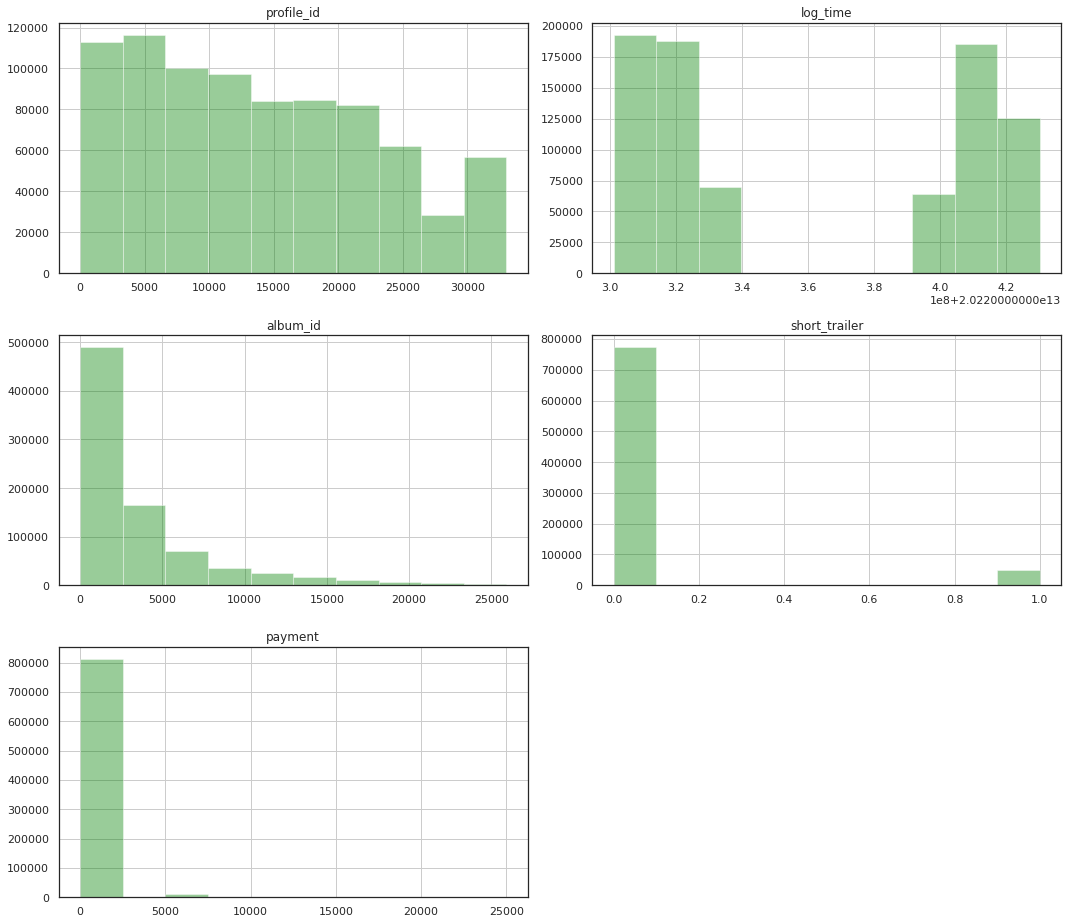

In [52]:
hd.hist(figsize = (15, 13), color = 'green', alpha = 0.4)
plt.tight_layout() # 그래프 간격 설정
plt.show()

<AxesSubplot:xlabel='payment', ylabel='Density'>

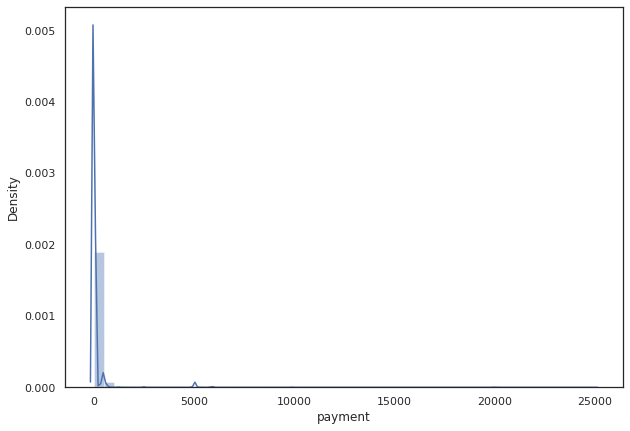

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(10, 7)})
sns.set(style="white")

sns.distplot(hd['payment']) #, kde_kws = {'color': 'g', 'alpha': 0.3,
                                       #            'linewidth': 5, 'shade': True})

<AxesSubplot:>

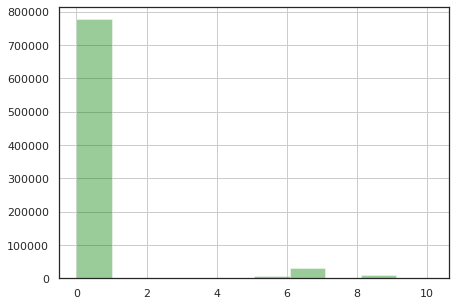

In [53]:
#로그변환
#np.log1p(df['col'])
np.log1p(hd['payment']).hist(figsize = (7, 5), color = 'green', alpha = 0.4)

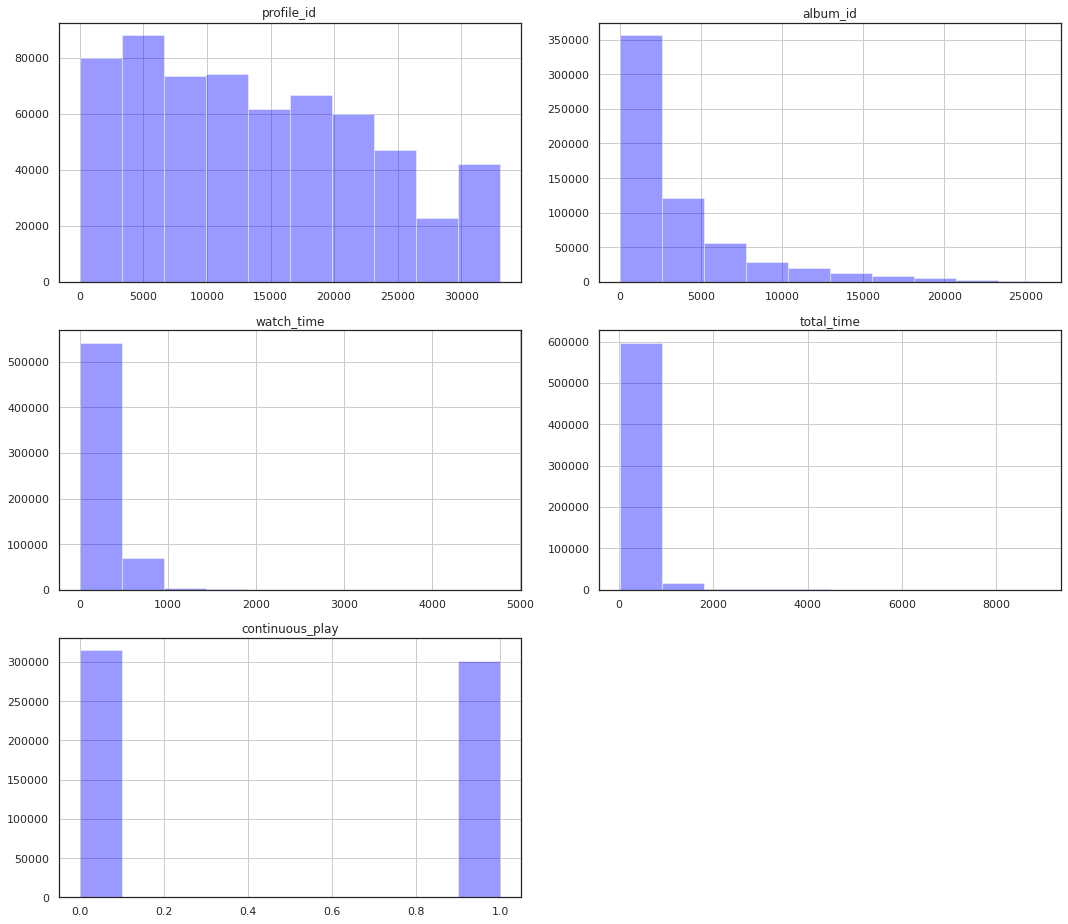

In [57]:
wd.hist(figsize = (15, 13), color = 'blue', alpha = 0.4)
plt.tight_layout() # 그래프 간격 설정
plt.show()

<AxesSubplot:>

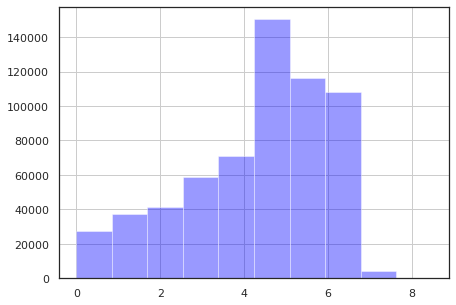

In [58]:
#로그변환
#np.log1p(df['col'])
np.log1p(wd['watch_time']).hist(figsize = (7, 5), color = 'blue', alpha = 0.4)

<AxesSubplot:>

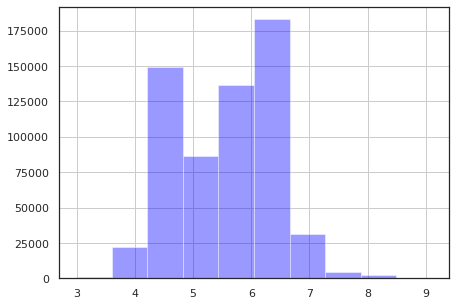

In [59]:
#로그변환
#np.log1p(df['col'])
np.log1p(wd['total_time']).hist(figsize = (7, 5), color = 'blue', alpha = 0.4)

- Skewed 확인 결과 : 로그변환 변수
    1. history_data : 'payment'
    2. watch_data : 'watch_time', 'total_time' 

In [62]:
# 로그변환
hd['payment'] = np.log1p(hd['payment'])
wd['watch_time'] = np.log1p(wd['watch_time'])
wd['total_time'] = np.log1p(wd['total_time'])

In [88]:
# 각 데이터셋 저장
hd.to_csv('hd_v1.csv')
wd.to_csv('wd_v1.csv')
sd.to_csv('sd_v1.csv')

### 6. 데이터 결합

In [64]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115719,003,15,1,0,0.0
1,3,20220301115809,003,16,1,0,0.0
2,3,20220301115958,003,17,1,0,0.0
3,3,20220301120118,003,18,1,0,0.0
4,3,20220301120229,003,19,1,0,0.0


In [65]:
wd.head()

,profile_id,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,049,15,3.850148,3.850148,1
1,3,049,16,4.653960,4.663439,1
2,3,049,17,4.343805,4.343805,1
3,3,049,18,4.219508,4.234107,1
4,3,049,19,4.510860,4.510860,0


In [66]:
%%time
df01 = pd.merge(hd, wd, on = ['profile_id', 'continuous_play'], how = 'outer')
df01

CPU times: user 44.9 s, sys: 12min 14s, total: 12min 59s
Wall time: 13min


,profile_id,log_time,act_target_dtl_x,album_id_x,continuous_play,short_trailer,payment,act_target_dtl_y,album_id_y,watch_time,total_time
0,3,2.022030e+13,003,15.0,1.0,0.0,0.0,049,15.0,3.850148,3.850148
1,3,2.022030e+13,003,15.0,1.0,0.0,0.0,049,16.0,4.653960,4.663439
2,3,2.022030e+13,003,15.0,1.0,0.0,0.0,049,17.0,4.343805,4.343805
3,3,2.022030e+13,003,15.0,1.0,0.0,0.0,049,18.0,4.219508,4.234107
4,3,2.022030e+13,003,15.0,1.0,0.0,0.0,049,20.0,4.787492,4.787492
...,...,...,...,...,...,...,...,...,...,...,...
159488494,33023,NaN,NaN,NaN,0.0,NaN,NaN,049,2331.0,4.787492,5.641907
159488495,33023,NaN,NaN,NaN,0.0,NaN,NaN,049,3005.0,6.200509,6.249975
159488496,33023,NaN,NaN,NaN,0.0,NaN,NaN,049,124.0,2.890372,5.953243
159488497,33023,NaN,NaN,NaN,0.0,NaN,NaN,049,190.0,1.386294,6.410175


In [71]:
df01.isnull().sum().to_frame()

,0
profile_id,0
log_time,72924
act_target_dtl_x,72924
album_id_x,72924
continuous_play,0
short_trailer,72924
payment,72924
act_target_dtl_y,18150
album_id_y,18150
watch_time,18150


In [68]:
sd.head()

,profile_id,log_time,act_target_dtl,album_id
0,59,20220303183914,017,2141
3,59,20220304181525,017,512
4,59,20220304182447,017,2141
5,59,20220312071637,017,2142
6,59,20220312081857,017,2142


In [69]:
df02 = pd.merge(df01, wd, on = ['profile_id'], how = 'outer')
df02

MemoryError: Unable to allocate 1.09 TiB for an array with shape (149876279065,) and data type int64

In [72]:
hd.head()

,profile_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115719,003,15,1,0,0.0
1,3,20220301115809,003,16,1,0,0.0
2,3,20220301115958,003,17,1,0,0.0
3,3,20220301120118,003,18,1,0,0.0
4,3,20220301120229,003,19,1,0,0.0


In [74]:
sd.head()

,profile_id,log_time,act_target_dtl,album_id
0,59,20220303183914,017,2141
3,59,20220304181525,017,512
4,59,20220304182447,017,2141
5,59,20220312071637,017,2142
6,59,20220312081857,017,2142


In [79]:
hd.shape

(825689, 7)

In [77]:
sd.shape

(5825, 4)

In [75]:
df03 = pd.merge(hd, sd, on = ['profile_id', 'album_id', 'log_time'], how = 'outer')
df03

,profile_id,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,act_target_dtl_y
0,3,20220301115719,003,15,1,0.0,0.0,NaN
1,3,20220301115809,003,16,1,0.0,0.0,NaN
2,3,20220301115958,003,17,1,0.0,0.0,NaN
3,3,20220301120118,003,18,1,0.0,0.0,NaN
4,3,20220301120229,003,19,1,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
831498,32965,20220423164503,NaN,23083,NaN,NaN,NaN,017
831499,32965,20220424065456,NaN,15080,NaN,NaN,NaN,017
831500,32965,20220425073358,NaN,15080,NaN,NaN,NaN,017
831501,32965,20220427063353,NaN,16497,NaN,NaN,NaN,017


In [76]:
df03.isnull().sum().to_frame()

,0
profile_id,0
log_time,0
act_target_dtl_x,5814
album_id,0
continuous_play,5814
short_trailer,5814
payment,5814
act_target_dtl_y,825678


In [78]:
831503 - 825678

5825

In [80]:
825689 + 5825

831514

In [81]:
df03[df03['act_target_dtl_x'].notnull() & df03['act_target_dtl_y'].notnull()] # 11개

,profile_id,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,act_target_dtl_y
163802,4561,20220422201944,003,1880,0,0.0,0.000000,017
169180,4731,20220315212907,003,10269,1,1.0,0.000000,017
315216,9368,20220403191440,003,4325,0,0.0,0.000000,017
315603,9368,20220422211315,003,8049,0,0.0,0.000000,017
315606,9368,20220422211610,003,8051,0,0.0,0.000000,017
315639,9368,20220423203800,003,8049,0,0.0,0.000000,017
398927,12124,20220323210528,003,424,0,0.0,0.000000,017
410607,12551,20220424122452,003,17486,0,0.0,0.000000,017
457647,14379,20220330232646,003,21350,0,0.0,6.216606,017
457948,14379,20220424195430,003,16783,0,0.0,6.216606,017


In [84]:
831503 + 11

831514

In [85]:
df04 = pd.merge(hd, sd, on = ['profile_id', 'album_id', 'log_time'], how = 'left')
df04

,profile_id,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,act_target_dtl_y
0,3,20220301115719,003,15,1,0,0.0,NaN
1,3,20220301115809,003,16,1,0,0.0,NaN
2,3,20220301115958,003,17,1,0,0.0,NaN
3,3,20220301120118,003,18,1,0,0.0,NaN
4,3,20220301120229,003,19,1,0,0.0,NaN
...,...,...,...,...,...,...,...,...
825684,33032,20220427155601,003,381,1,0,0.0,NaN
825685,33032,20220427155611,003,381,1,0,0.0,NaN
825686,33032,20220427155642,003,381,0,0,0.0,NaN
825687,33032,20220427155810,003,125,1,0,0.0,NaN


In [86]:
831503 - 11

831492

In [87]:
df04.isnull().sum().to_frame()

,0
profile_id,0
log_time,0
act_target_dtl_x,0
album_id,0
continuous_play,0
short_trailer,0
payment,0
act_target_dtl_y,825678
